## Predict Country from Given Capital

In [1]:
# import packages.
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('./data/capitals.txt', delimiter=' ')
data.columns = ['city1', 'country1', 'city2', 'country2']

# print first five elements in the DataFrame
data.head(5)

# city 1 and country 1 respectively known
# given city2 predict country2

,city1,country1,city2,country2
0,Athens,Greece,Bangkok,Thailand
1,Athens,Greece,Beijing,China
2,Athens,Greece,Berlin,Germany
3,Athens,Greece,Bern,Switzerland
4,Athens,Greece,Cairo,Egypt


https://code.google.com/archive/p/word2vec/

GoogleNews-vectors-negative300.bin.gz

In [3]:
word_embeddings = pickle.load(open("./data/word_embeddings_subset.p", "rb"))
len(word_embeddings)

243

In [4]:
print("dimension: {}".format(word_embeddings['Spain'].shape[0]))

dimension: 300


In [5]:
def cosine_similarity(A, B):
    '''
    Input:
        A: a numpy array which corresponds to a word vector
        B: A numpy array which corresponds to a word vector
    Output:
        cos: numerical number representing the cosine similarity between A and B.
    '''
    dot = np.dot(A,B)
    norma = np.linalg.norm(A)
    normb = np.linalg.norm(B)
    cos = dot / (norma * normb)
    
    return cos

In [6]:
king = word_embeddings['king']
queen = word_embeddings['queen']

cosine_similarity(king, queen)

0.6510957

In [7]:
def euclidean(A, B):
    """
    Input:
        A: a numpy array which corresponds to a word vector
        B: A numpy array which corresponds to a word vector
    Output:
        d: numerical number representing the Euclidean distance between A and B.
    """
    # euclidean distance
    d = np.linalg.norm(A - B)

    return d

In [8]:
euclidean(king, queen)

2.4796925

In [9]:
def get_country(city1, country1, city2, embeddings):
    """
    Input:
        city1: a string (the capital city of country1)
        country1: a string (the country of capital1)
        city2: a string (the capital city of country2)
        embeddings: a dictionary where the keys are words and values are their embeddings
    Output:
        countries: a dictionary with the most likely country and its similarity score
    """
    group = set((city1, country1, city2))
    city1_emb = embeddings[city1]
    country1_emb = embeddings[country1]
    city2_emb = embeddings[city2]

    # Remember: King - Man + Woman = Queen
    vec = country1_emb - city1_emb + city2_emb

    # Initialize the similarity to -1 (it will be replaced by a similarities that are closer to +1)
    similarity = -1
    country = ''

    for word in embeddings.keys():
        if word not in group:
            word_emb = embeddings[word]
            cur_similarity = cosine_similarity(vec, word_emb)
            if cur_similarity > similarity:
                similarity = cur_similarity
                country = (word, similarity)

    return country

In [10]:
get_country('Athens', 'Greece', 'Cairo', word_embeddings)

('Egypt', 0.7626821)

In [11]:
def get_accuracy(word_embeddings, data):
    '''
    Input:
        word_embeddings: a dictionary where the key is a word and the value is its embedding
        data: a pandas dataframe containing all the country and capital city pairs
    
    Output:
        accuracy: the accuracy of the model
    '''
    num_correct = 0

    for i, row in data.iterrows():
        city1 = row['city1']
        country1 = row['country1']
        city2 =  row['city2']
        country2 = row['country2']

        predicted_country2, _ = get_country(city1, country1, city2, word_embeddings)
        if predicted_country2 == country2:
            num_correct += 1
        
    m = len(data)
    accuracy = num_correct / m
    
    return accuracy

In [12]:
accuracy = get_accuracy(word_embeddings, data)
print(f"Accuracy is {accuracy:.2f}")

Accuracy is 0.92


In [13]:
def compute_pca(X, n_components=2):
    """
    Input:
        X: of dimension (m,n) where each row corresponds to a word vector
        n_components: Number of components you want to keep.
    Output:
        X_reduced: data transformed in 2 dims/columns + regenerated original data
    """
    # Demeaning a data set refers to the process of subtracting the mean value of the data from each individual data point.
    X_demeaned = X - np.mean(X,axis=0)
    covariance_matrix = np.cov(X_demeaned, rowvar=False)
    eigen_vals, eigen_vecs = np.linalg.eigh(covariance_matrix, UPLO='L')
    idx_sorted_decreasing = (np.argsort(eigen_vals))[::-1] # highest to lowest
    eigen_vecs_sorted = eigen_vecs[:, idx_sorted_decreasing]
    eigen_vecs_subset = eigen_vecs_sorted[:, 0:n_components]
    X_reduced = np.dot(eigen_vecs_subset.T, X_demeaned.T).T

    return X_reduced

In [14]:
# Test
np.random.seed(1)
X = np.random.rand(3, 10)
X_reduced = compute_pca(X, n_components=2)
print("Your original matrix was " + str(X.shape) + " and it became:")
print(X_reduced)

Your original matrix was (3, 10) and it became:
[[ 0.43437323  0.49820384]
 [ 0.42077249 -0.50351448]
 [-0.85514571  0.00531064]]


In [15]:
def get_vectors(embeddings, words):
    """
    Input:
        embeddings: a word 
        fr_embeddings:
        words: a list of words
    Output: 
        X: a matrix where the rows are the embeddings corresponding to the rows on the list
        
    """
    m = len(words)
    X = np.zeros((1, 300))
    for word in words:
        english = word
        eng_emb = embeddings[english]
        X = np.row_stack((X, eng_emb))
    X = X[1:,:]
    return X

In [16]:
X1 = get_vectors(word_embeddings, data['city2'])
X2 = get_vectors(word_embeddings, data['country2'])
X = np.concatenate((X1, X2), axis=1)

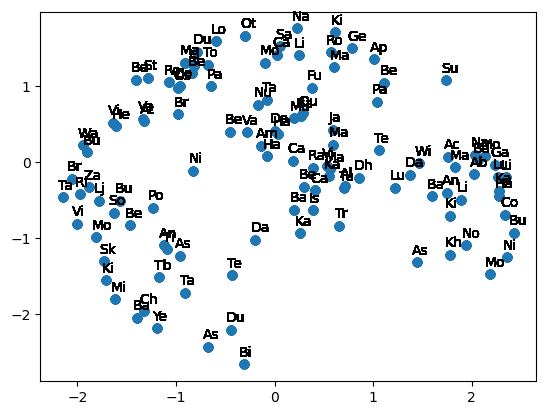

In [17]:
result = compute_pca(X, 2)
plt.scatter(result[:, 0], result[:, 1])
for i, word in enumerate(data['city2']+data['country2']):
    plt.annotate(word[:2], xy=(result[i, 0] - 0.05, result[i, 1] + 0.1))

plt.show()